In [31]:
import sys
import pandas as pd
from scipy.stats import spearmanr,kendalltau
import numpy as np
from sklearn.utils import resample
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean, var, sqrt

In [2]:
df = pd.read_csv("xgboost_result.csv")

In [3]:
df.head()

,Method,Dataset,CV_Cycle,Name,Truth,Pred
0,desc,A2a,0,CHEMBL162826,9.16,9.198373
1,desc,A2a,0,CHEMBL360876,6.28,6.527542
2,desc,A2a,0,CHEMBL77921,5.47,6.116292
3,desc,A2a,0,CHEMBL181184,6.41,6.902563
4,desc,A2a,0,CHEMBL311469,4.68,6.284432


In [25]:
def cohend(d1, d2):
    """
    Function to calculate Cohen's d, taken from https://machinelearningmastery.com/effect-size-measures-in-python/
    :param d1: result1
    :param d2: result2
    :return: Cohen's d
    """
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [105]:
def evaluate_cohend(df, label_1, label_2, stat_method):
    """
    Take a dataframe with predicted and experimental values for two methods and calculate Cohen's d
    :param df: input dataframe should have columns ["DataSet", "Method", "CV Cycle"]
    :param label_1: label for the first method in the "Method" column
    :param label_2: label for the second method in the "Method" column
    :param stat_method: statistic to use, method should return a tuple with the value of interest as element 0
    :return: a dataframe containing 
    """
    gb = df.groupby(["Dataset"])
    cohen_list = []
    for k, v in tqdm(gb):
        delta_list = []
        corr_list = []
        for kk, vv in v.groupby("CV_Cycle"):
            truth_1 = vv.query(f"Method == '{label_1}'").Truth.values
            pred_1 = vv.query(f"Method == '{label_1}'").Pred.values
            truth_2 = vv.query(f"Method == '{label_2}'").Truth.values
            pred_2 = vv.query(f"Method == '{label_2}'").Pred.values
            stat_1 = stat_method(truth_1, pred_1)
            stat_2 = stat_method(truth_2, pred_2)
            corr_list.append([stat_1[0], stat_2[0]])
            delta_list.append(stat_1[0] - stat_2[0])
        corr_1 = [x[0] for x in corr_list]
        corr_2 = [x[1] for x in corr_list]
        cohen_list.append([k, np.mean(corr_1), np.mean(corr_2), cohend(corr_1, corr_2)])
    return pd.DataFrame(cohen_list, columns=["Target", label_1 + " mean", label_2 + " mean", "Cohen's d"])

In [106]:
cohen_df = evaluate_cohend(df,"cddd","desc",spearmanr)

100%|██████████| 24/24 [00:01<00:00, 13.22it/s]


In [114]:
pd.options.display.float_format = '{:,.2f}'.format

In [115]:
cohen_df.sort_values("Target",ascending=False)

,Target,cddd mean,desc mean,Cohen's d
23,opioid,0.76,0.81,-2.36
22,erbB1,0.77,0.80,-3.28
21,Vanilloid,0.63,0.66,-0.96
20,Monoamine,0.64,0.67,-1.21
19,LCK,0.68,0.72,-1.49
18,JAK2,0.71,0.76,-3.01
17,HERG,0.59,0.63,-2.36
16,Glycogen,0.69,0.74,-2.35
15,Glucocorticoid,0.76,0.77,-0.55
14,Estrogen,0.83,0.86,-1.84


In [86]:
cohen_df["Cohen's d"].mean()

-1.6686428492386813

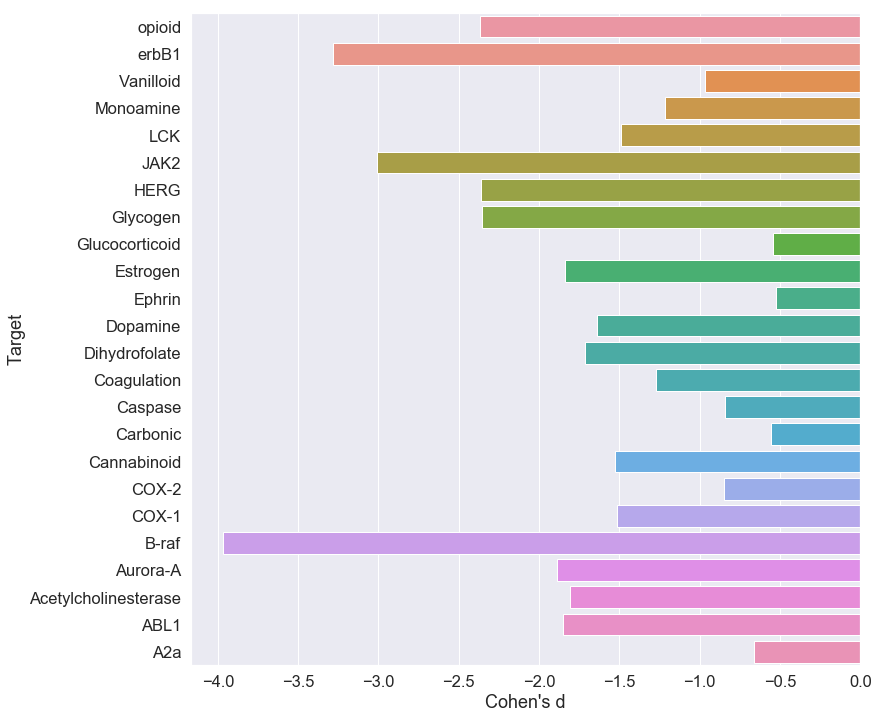

In [103]:
ax = sns.barplot(y="Target",x="Cohen's d",data=cohen_df,order=sorted(cohen_df.Target,reverse=True))
sns.set(rc={'figure.figsize': (8, 12)})
sns.set(font_scale=1.5)